### TS with CNN, ref: pag.263 Brownlee

In [2]:
# evaluate cnn for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from matplotlib import pyplot
import pandas as pd 

### Example with a CHINA EV sales dataset

In [3]:
#data source: https://datasetsearch.research.google.com/search?query=univariate%20time%20series&docid=Z2B66b7T3lUIl0y6AAAAAA%3D%3D&filters=bm9uZQ%3D%3D&property=aXNfYWNjZXNzaWJsZV9mb3JfZnJlZQ%3D%3D
ev_sales_data = read_csv(r'.\datasets\china_electric_vehicles_sales.csv')

ev_sales_data['Date'] = pd.to_datetime(ev_sales_data['Year/Month'])
ev_sales_data.set_index('Date', inplace=True)
ev_sales_data.drop(columns=['Year/Month'], inplace=True)

sales_series_values = ev_sales_data['sales'].values
ev_sales_data.head(5)

,BEV,sales
Date,,
2011-01-01,588,310
2011-02-01,47,417
2011-03-01,159,286
2011-04-01,173,162
2011-05-01,305,470


In [ ]:
def make_line_plots(title, dataset, attributes_to_plot=[], x_axis_label='x', y_axis_label='y', 
                        background_color=None, legend_location="top_left", line_colors=['red'],
                        x_axis_type=None, tools = "pan,wheel_zoom,box_zoom,reset"):
        try:
            from bokeh.plotting import figure, show, output_file
            from bokeh.models import HoverTool
            from bokeh.io import output_notebook

            output_notebook()

            p = figure(title=title, x_axis_type=x_axis_type, tools=tools, background_fill_color=background_color)
            p.legend.location = legend_location

            #x_values = dataset.index
            x_values = pd.to_datetime(dataset.index)
            i = 0
            for attribute in attributes_to_plot:
                    attribute_values = dataset[attribute]
                    p.line(x_values, attribute_values, legend=attribute, line_dash=[4, 4], line_color=line_colors[i], 
                            line_width=2)
                    i += 1


            p.y_range.start = 0
            p.legend.location = legend_location
            p.legend.background_fill_color = background_color
            p.xaxis.axis_label = x_axis_label
            p.yaxis.axis_label = y_axis_label
            p.grid.grid_line_color="white"

            p.add_tools(HoverTool())
            p.select_one(HoverTool).tooltips = [
                                    (x_axis_label, '@x'),
                                    (y_axis_label, '@y'),
                                ]
                                
            p.legend.click_policy="hide"

            show(p)

        except Exception as exc:
            return exc
            #logger.exception('raised exception at {}: {}'.format(logger.name+'.'+make_line_plots.__name__, exc))


In [7]:
make_line_plots('EV monthly sales', ev_sales_data, attributes_to_plot=['sales'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue'], x_axis_type="datetime")



Loading BokehJS ...

In [4]:
ev_sales_data['year'] = pd.Series(ev_sales_data.index).apply(lambda x: x.year).values
ev_sales_data['month'] = pd.Series(ev_sales_data.index).apply(lambda x: x.month).values
ev_sales_data.head(5)

,BEV,sales,year,month
Date,,,,
2011-01-01,588,310,2011,1
2011-02-01,47,417,2011,2
2011-03-01,159,286,2011,3
2011-04-01,173,162,2011,4
2011-05-01,305,470,2011,5


In [16]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-int(n_test)], data[-int(n_test):]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values


### Aquí se crean las series de datos que se componen de datos de cada 5 meses (n_in) del histórico

In [17]:
train, test = train_test_split(sales_series_values, 10)
n_in = 5 #5 meses por ej
agg_values = series_to_supervised(train, n_in, n_out=1)

import pandas as pd 
pd.DataFrame(agg_values)


,0,1,2,3,4,5
0,310.0,417.0,286.0,162.0,470.0,273.0
1,417.0,286.0,162.0,470.0,273.0,650.0
2,286.0,162.0,470.0,273.0,650.0,1323.0
3,162.0,470.0,273.0,650.0,1323.0,688.0
4,470.0,273.0,650.0,1323.0,688.0,663.0
5,273.0,650.0,1323.0,688.0,663.0,896.0
6,650.0,1323.0,688.0,663.0,896.0,443.0
7,1323.0,688.0,663.0,896.0,443.0,216.0
8,688.0,663.0,896.0,443.0,216.0,512.0
9,663.0,896.0,443.0,216.0,512.0,826.0


### me salen 45 porque tenemos 10 meses de test, nos quedan 50 meses de train, que en batches de 5 meses son 45 registros de 5 meses each

In [18]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu',
              input_shape=(n_input, 1)))
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)


    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

In [19]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)

    return error, predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    predictions_matrix = []
    scores = []
    #scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    
    for _ in range(n_repeats):
        score, predictions = walk_forward_validation(data, n_test, config) 
        scores.append(score)
        predictions_matrix.append(predictions)
    
    return scores, predictions_matrix

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()


In [20]:
# data split
n_test = 10.0 #int(0.1*len(sales_series_values))
# define config
config = [6, 256, 2, 50, 100]
# grid search
scores, predictions_matrix = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)


> 2176.937
 > 2237.959
 > 2168.013
 > 2078.213
 > 2178.878
 > 2197.512
 > 2332.101
 > 2214.058
 > 2024.776
 > 2167.377
 > 2118.623
 > 2095.436
 > 2119.571
 > 2184.620
 > 2200.916
 > 2188.006
 > 2071.976
 > 2122.366
 > 2229.352
 > 2158.989
 > 2250.479
 > 2046.707
 > 2009.540
 > 2140.236
 > 2118.443
 > 2291.115
 > 2099.236
 > 2174.615
 > 2141.986
 > 2252.869


cnn: 2159.697 RMSE (+/- 74.417)


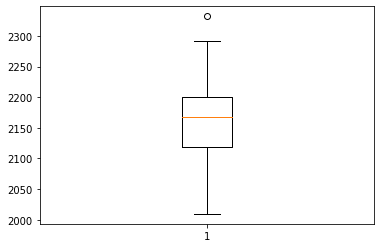

In [21]:
# summarize scores
summarize_scores('cnn', scores)


### HEMOS REDUCIDO A MENOS DE LA MITAD EL ERROR OBTENIDO CON EL MLP

In [30]:
ev_sales_forecast_df = pd.DataFrame()

test_rmse = measure_rmse(ev_sales_data['sales'][-int(n_test):].values, predictions_matrix[-1])
if int(test_rmse) == int(scores[-1]): 
    ev_sales_forecast_df['sales_test_values'] = ev_sales_data['sales'][-int(n_test):]
    ev_sales_forecast_df['sales_CNN_predictions'] = predictions_matrix[-1]

ev_sales_forecast_df

,sales_test_values,sales_CNN_predictions
Date,,
2015-03-01,4079,[6344.968]
2015-04-01,5730,[5970.584]
2015-05-01,6354,[6524.37]
2015-06-01,8308,[6430.001]
2015-07-01,7338,[7015.1895]
2015-08-01,12085,[8046.3105]
2015-09-01,12736,[9338.225]
2015-10-01,11384,[11227.162]
2015-11-01,11402,[12981.836]


In [31]:
make_line_plots('EV monthly sales predictions', ev_sales_forecast_df, attributes_to_plot=['sales_test_values', 'sales_CNN_predictions'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue', 'red'], x_axis_type="datetime")

Loading BokehJS ...

C:\Users\gcabreram\AppData\Local\Continuum\anaconda3\envs\deep_learning_tf2_env\lib\site-packages\bokeh\models\plots.py:767: UserWarning: 
You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)
